### Actividad de perceptrón y perceptrón multicapa
#### Autor: Francisco Serradilla

Tareas:

- Escribir el código de propagación y actualización de pesos del perceptrón.
- Escribir el código de propagación y actualización de pesos del perceptrón multicapa para una capa oculta.
- Probar el correcto funcionamiento con OR y con XOR.
- Probar el correcto funcionamiento para las distribuciones generadas en el notebook. Dibujar los resultados.

Opcional:
- Problema de clasificación de orquídeas.
- Ampliar el código del perceptrón Multicapa para calcular el error de test usando otro conjunto de datos. Este error de test se irá mostrando a la vez que el error de entrenamiento mientras la red se entrena.
- Probar entrenamiento y cálculo del error de test con el juego de datos de aprobados.
- (hacer al menos dos) Probar con problemas adicionales (circulo, fun, morosos, quinielas). Al final hay una explicación de los conjuntos de datos suministrados.
- (opcional) Añadir una segunda capa oculta al perceptrón multacapa y/o un múmero indefinido de capas.

In [1]:
import numpy as np

class Perceptron:
    def __init__(self, ninput, noutput):
        self.ninput = ninput # número de entradas
        self.noutput = noutput # número de salidas
        self.w = np.random.rand(ninput,noutput)-0.5 # pesos
        self.b = np.random.rand(noutput)-0.5 # bias
    
    def step (self, x): # función de activación
        return np.where(x<0,0,1) 

    def forward (self, x): # propaga un vector x y devuelve la salida
        z = np.dot(x, self.w) + self.b 
        return self.step(z)
    
    def update (self, x, d, alpha): # realiza una iteración de entrenamiento
        s = self.forward(x) # propaga
        # self.w = self.w + alpha*np.outer(x,d-s) # ajusta pesos
        self.w = self.w + alpha * (x*(d-s)).reshape(self.ninput,self.noutput) # ajusta pesos
        
        self.b = self.b + alpha*(d-s)
        
    def RMS (self, X, D): # calcula el error RMS
        S = self.forward(X)
        return np.mean(np.sqrt(np.mean(np.square(S-D),axis=1)))
        
    def accuracy (self, X, D): # calcula el ratio de aciertos
        S = self.forward(X)
        errors = np.mean(np.abs(D-S))
        return 1.0 - errors
    
    def info (self, X, D): # traza de cómno va el entrenamiento
        print(f'RMS: {self.RMS(X,D):.4f}')
        print(f'Accuracy: {self.accuracy(X,D):.4f}')
        
    def train (self, X, D, alpha, epochs, trace=0): # entrena usando update
        for e in range(1,epochs+1): # para cada epoch
            for i in range(len(X)): # para cada ejemplo
                self.update(X[i],D[i], alpha)
            if trace!=0 and e%trace == 0: # imprime trazas
                print('\n   Epoch: %d' % e)
                self.info(X,D)

In [5]:
# entrena para la OR

p = Perceptron(ninput=2,noutput=1)

# or
data = np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
labels = np.array([[0.0], [1.0], [1.0], [1.0]])

p.train(data, labels, alpha=0.1, epochs=50, trace=10)
p.info(data, labels)


   Epoch: 10
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 20
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 30
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 40
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 50
RMS: 0.0000
Accuracy: 1.0000
RMS: 0.0000
Accuracy: 1.0000


In [6]:
class Multilayer:
    def __init__(self, ninput, nhidden, noutput):
        '''
        ninput: número de neuronas de entrada
        nhidden: número de neuronas ocultas
        noutput: número de neuronas de salida
        '''
        self.ninput = ninput # número de entradas
        self.nhidden = nhidden # número de neuronas en capa oculta
        self.noutput = noutput # número de salidas

        # pesos y bías de la capa 1
        self.w1 = np.random.rand(ninput,nhidden)-0.5
        self.b1 = np.random.rand(nhidden)-0.5
        # pesos y bías de la capa 2
        self.w2 = np.random.rand(nhidden,noutput)-0.5
        self.b2 = np.random.rand(noutput)-0.5
        
        self.lRMS = [] # contiene la lista de RMSs para pintarlos luego
        self.laccuracy = [] # contiene la lista de accuracy para pintar luego

    def sigm (self, neta): # función sigmoidal
        return 1.0 / (1.0 + np.exp(-neta))
    
    def forward (self, x): # propaga un vector x y devuelve la salida
        neta1 = np.dot(x, self.w1) + self.b1
        y1 = self.sigm(neta1)
        neta2 = np.dot(y1, self.w2) + self.b2
        y2 = self.sigm(neta2)
        return y2
    
    def update (self, x, d, alpha): # realiza una iteración de entrenamiento
        # Propagación hacia adelante
        neta1 = np.dot(x, self.w1) + self.b1
        y1 = self.sigm(neta1)
        neta2 = np.dot(y1, self.w2) + self.b2
        y2 = self.sigm(neta2)
        
        # Propagación hacia atrás
        # Entrenamiento de pesos y bias en la capa de salida.
        deltas2 = (d-y2) * y2 * (1-y2)
        # Entrenamiento de pesos y bias en la capa oculta.
        deltas1 = np.dot(self.w2, deltas2) * y1 * (1-y1)
        # Actualización de pesos y bias
        self.w2 = self.w2 + alpha * np.outer(y1, deltas2)
        self.b2 = self.b2 + alpha * deltas2
        self.w1 = self.w1 + alpha * np.outer(x, deltas1)
        self.b1 = self.b1 + alpha * deltas1
        
    def RMS (self, X, D): # error RMS
        S = self.forward(X)
        return np.mean(np.sqrt(np.mean(np.square(S-D),axis=1)))
        
    def accuracy (self, X, D): # calcula ratio de aciertos
        S = self.forward(X)
        S = np.round(S)
        errors = np.mean(np.abs(D-S))
        return 1.0 - errors
    
    def info (self, X, D): # escribe traza
        self.lRMS.append(self.RMS(X,D))
        self.laccuracy.append(self.accuracy(X,D))
        print('     RMS: %6.5f' % self.lRMS[-1])
        print('Accuracy: %6.5f' % self.laccuracy[-1])
        
    def train (self, X, D, alpha, epochs, trace=0): # entrena usando update
        self.lRMS = [] # guarda lista de RMSs para pintarlos
        self.laccuracy = [] # guarda lista de accuracy

        for e in range(1,epochs+1): # para cada epoch
            for i in range(len(X)): # para cada ejemplo
                self.update(X[i],D[i], alpha)
            if trace!=0 and e%trace == 0: # escribe traza si corresponde
                print('\n   Epoch: %d' % e)
                self.info(X,D)
                
def one_hot (d): # codificación one_hot
    num_classes = len(set(d))
    rows = d.shape[0]
    labels = np.zeros((rows, num_classes), dtype='float32')
    labels[np.arange(rows),d.T] = 1
    return labels

In [7]:
# xor
data = np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
labels = np.array([[0.0], [1.0], [1.0], [0.0]])

p = Multilayer(2,2,1)

p.info(data, labels)


     RMS: 0.49992
Accuracy: 0.50000


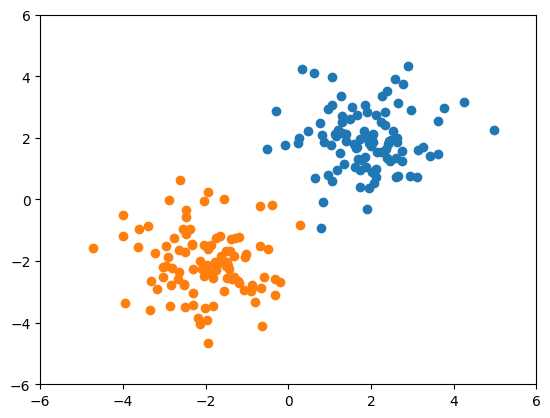

In [16]:
import numpy as np

# example data from two classes; 2D normal distributions
num = 100
x0 = np.random.multivariate_normal([2,2], np.array([[1,0],[0,1]]),num)
d0 = np.repeat(0, num)
x1 = np.random.multivariate_normal([-2,-2], np.array([[1,0],[0,1]]),num)
d1 = np.repeat(1, num)

import matplotlib.pyplot as plt
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.plot(x0[:,0],x0[:,1],'o')
plt.plot(x1[:,0],x1[:,1],'o')

plt.show()

X = np.vstack((x0,x1))
d = np.hstack((d0,d1))
d.shape = (200,1) # convierte el vector en un array

In [17]:
# entrenar

p = Perceptron(2,1)
p.train(X, d, 0.01, 10, 1)


   Epoch: 1
RMS: 0.0150
Accuracy: 0.9850

   Epoch: 2
RMS: 0.0150
Accuracy: 0.9850

   Epoch: 3
RMS: 0.0150
Accuracy: 0.9850

   Epoch: 4
RMS: 0.0100
Accuracy: 0.9900

   Epoch: 5
RMS: 0.0100
Accuracy: 0.9900

   Epoch: 6
RMS: 0.0100
Accuracy: 0.9900

   Epoch: 7
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 8
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 9
RMS: 0.0000
Accuracy: 1.0000

   Epoch: 10
RMS: 0.0000
Accuracy: 1.0000


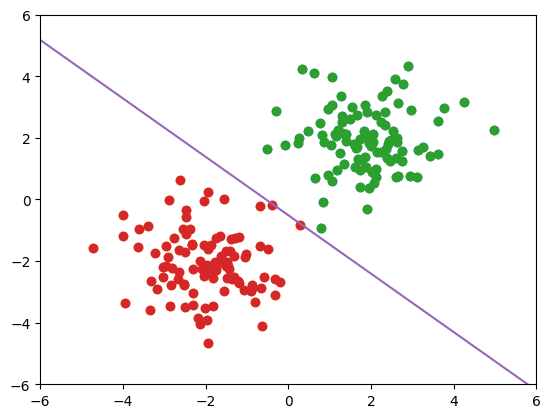

In [20]:
# Dibujar el resultado de la clasificación por el perceptrón
import numpy as np
import matplotlib.pyplot as plt
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.plot(x0[:,0],x0[:,1],'o')
plt.plot(x1[:,0],x1[:,1],'o')
x_line = np.linspace(-6,6,100)
y_line = -p.w[0]/p.w[1]*x_line - p.b/p.w[1]
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.plot(x0[:,0],x0[:,1],'o')
plt.plot(x1[:,0],x1[:,1],'o')
plt.plot(x_line, y_line)

plt.show()

X = np.vstack((x0,x1))
d = np.hstack((d0,d1))
d.shape = (200,1) # convierte el vector en un array

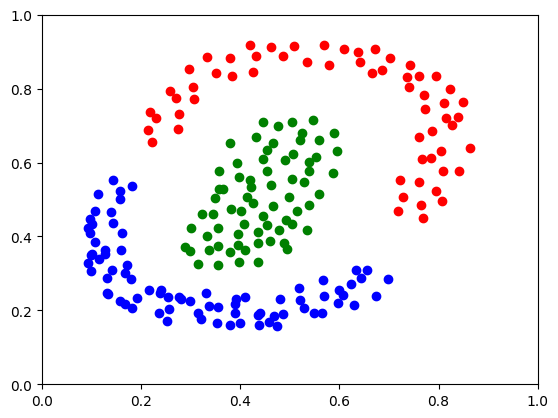

In [21]:
# regiones no lineales

X = np.loadtxt('samples/data_3classes_nonlinear_2D.txt')

d = X[:,-1].astype('int')
X = X[:,:-1]

plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(X[d==0,0],X[d==0,1], 'ro')
plt.plot(X[d==1,0],X[d==1,1], 'go')
plt.plot(X[d==2,0],X[d==2,1], 'bo')

plt.show()

no = len(set(d))
ni = X.shape[1]

d = one_hot(d)

In [30]:
# entrenar
# encontrar arquitectura mínima que aprende este problema, para data_2classes_nonlinear_2D.txt y para data_3classes_nonlinear_2D.txt

p = Multilayer(ni, 15, no)
p.train(X, d, alpha=0.1, epochs=1000, trace=100)
p.info(X, d)


   Epoch: 100
     RMS: 0.31885
Accuracy: 0.74921

   Epoch: 200
     RMS: 0.28590
Accuracy: 0.78095

   Epoch: 300
     RMS: 0.24618
Accuracy: 0.84444

   Epoch: 400
     RMS: 0.22597
Accuracy: 0.85079

   Epoch: 500
     RMS: 0.21636
Accuracy: 0.85397

   Epoch: 600
     RMS: 0.20433
Accuracy: 0.87302

   Epoch: 700
     RMS: 0.14624
Accuracy: 0.95079

   Epoch: 800
     RMS: 0.09066
Accuracy: 0.98889

   Epoch: 900
     RMS: 0.06456
Accuracy: 0.99841

   Epoch: 1000
     RMS: 0.05142
Accuracy: 1.00000
     RMS: 0.05142
Accuracy: 1.00000


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10208\4251807264.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


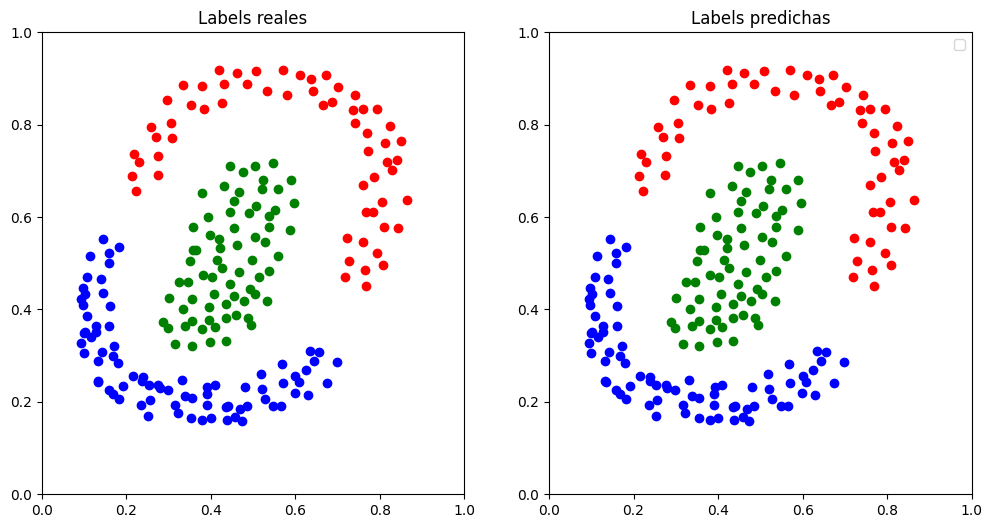

In [40]:
# Dibujar el resultado de la clasificación por el multicapa, comparar con las salidas que debería dar

# Propagate the inputs through the network
predictions = p.forward(X)
# print(predictions)
# Clasificar las predicciones cogiendo el índice de la neurona con mayor valor.
predicted_labels = np.argmax(predictions, axis=1)

# Clasificar las salidas reales cogiendo el índice de la neurona con valor 1.
true_labels = np.argmax(d, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the true labels
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].plot(X[true_labels == 0, 0], X[true_labels == 0, 1], 'ro')
axs[0].plot(X[true_labels == 1, 0], X[true_labels == 1, 1], 'go')
axs[0].plot(X[true_labels == 2, 0], X[true_labels == 2, 1], 'bo')
axs[0].set_title('Labels reales')

# Plot the predicted labels
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].plot(X[predicted_labels == 0, 0], X[predicted_labels == 0, 1], 'ro')
axs[1].plot(X[predicted_labels == 1, 0], X[predicted_labels == 1, 1], 'go')
axs[1].plot(X[predicted_labels == 2, 0], X[predicted_labels == 2, 1], 'bo')
axs[1].set_title('Labels predichas')
axs[1].legend()

plt.show()

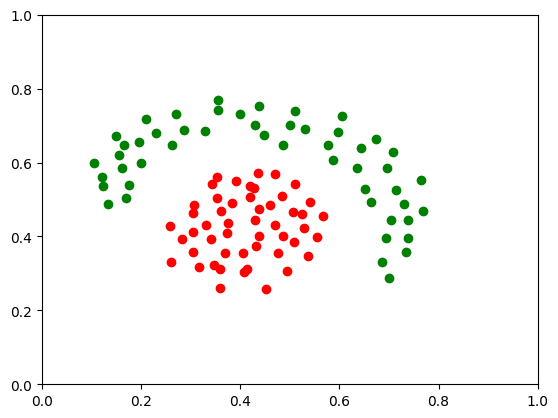

In [41]:
# regiones no lineales

X = np.loadtxt('samples/data_2classes_nonlinear_2D.txt')

d = X[:,-1].astype('int')
X = X[:,:-1]

plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(X[d==0,0],X[d==0,1], 'ro')
plt.plot(X[d==1,0],X[d==1,1], 'go')
plt.plot(X[d==2,0],X[d==2,1], 'bo')

plt.show()

no = len(set(d))
ni = X.shape[1]

d = one_hot(d)

In [42]:
# entrenar
# encontrar arquitectura mínima que aprende este problema, para data_2classes_nonlinear_2D.txt y para data_3classes_nonlinear_2D.txt

p = Multilayer(ni, 15, no)
p.train(X, d, alpha=0.1, epochs=1000, trace=100)
p.info(X, d)


   Epoch: 100
     RMS: 0.39051
Accuracy: 0.78500

   Epoch: 200
     RMS: 0.29178
Accuracy: 0.81000

   Epoch: 300
     RMS: 0.27240
Accuracy: 0.81000

   Epoch: 400
     RMS: 0.26690
Accuracy: 0.80500

   Epoch: 500
     RMS: 0.26616
Accuracy: 0.80000

   Epoch: 600
     RMS: 0.26298
Accuracy: 0.81000

   Epoch: 700
     RMS: 0.23714
Accuracy: 0.85000

   Epoch: 800
     RMS: 0.16323
Accuracy: 0.96000

   Epoch: 900
     RMS: 0.11007
Accuracy: 1.00000

   Epoch: 1000
     RMS: 0.08379
Accuracy: 1.00000
     RMS: 0.08379
Accuracy: 1.00000


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10208\4251807264.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


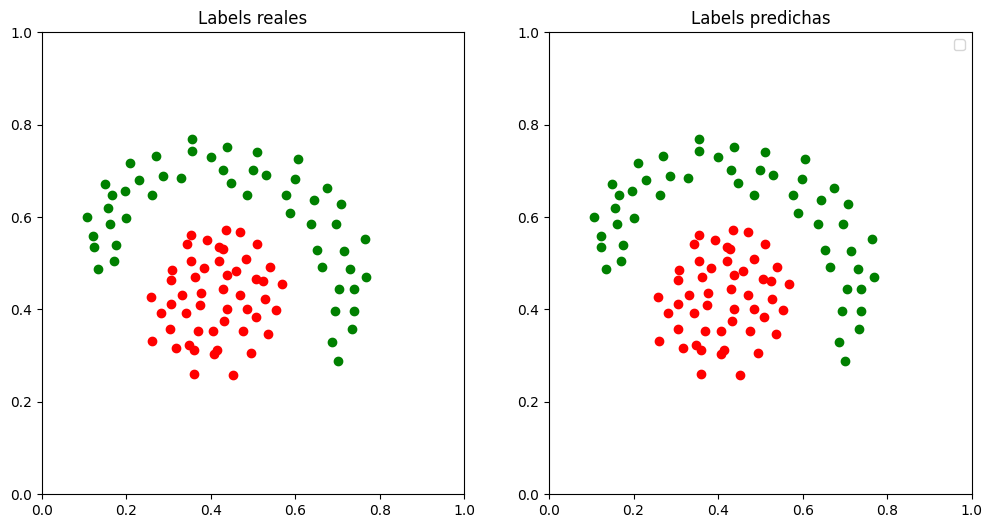

In [43]:
# Dibujar el resultado de la clasificación por el multicapa, comparar con las salidas que debería dar

# Propagate the inputs through the network
predictions = p.forward(X)
# print(predictions)
# Clasificar las predicciones cogiendo el índice de la neurona con mayor valor.
predicted_labels = np.argmax(predictions, axis=1)

# Clasificar las salidas reales cogiendo el índice de la neurona con valor 1.
true_labels = np.argmax(d, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the true labels
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].plot(X[true_labels == 0, 0], X[true_labels == 0, 1], 'ro')
axs[0].plot(X[true_labels == 1, 0], X[true_labels == 1, 1], 'go')
axs[0].plot(X[true_labels == 2, 0], X[true_labels == 2, 1], 'bo')
axs[0].set_title('Labels reales')

# Plot the predicted labels
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].plot(X[predicted_labels == 0, 0], X[predicted_labels == 0, 1], 'ro')
axs[1].plot(X[predicted_labels == 1, 0], X[predicted_labels == 1, 1], 'go')
axs[1].plot(X[predicted_labels == 2, 0], X[predicted_labels == 2, 1], 'bo')
axs[1].set_title('Labels predichas')
axs[1].legend()

plt.show()

CSV Iris

In [68]:
# Orquideas

X = np.loadtxt('samples/iris.csv', dtype = 'float64', usecols = [0,1,2,3])
L = np.loadtxt('samples/iris.csv', dtype = str, usecols = [4]) 

# convierte la salida a enteros
d = []
options = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
for e in L:
    d.append(options.index(e))

d = np.array(d)
X = np.array(X)

d = one_hot(d)

ni = X.shape[1]
no = len(options)

p = Multilayer(ni,40,no)

# encontrar arquitectura mínima que aprende este problema
p = Multilayer(ni, 15, no)
p.train(X, d, alpha=0.1, epochs=30000, trace=100)
p.info(X, d)


   Epoch: 100
     RMS: 0.12401
Accuracy: 0.92000

   Epoch: 200
     RMS: 0.07603
Accuracy: 0.95556

   Epoch: 300
     RMS: 0.04767
Accuracy: 0.97111

   Epoch: 400
     RMS: 0.04219
Accuracy: 0.97556

   Epoch: 500
     RMS: 0.04149
Accuracy: 0.97333

   Epoch: 600
     RMS: 0.03848
Accuracy: 0.97333

   Epoch: 700
     RMS: 0.03579
Accuracy: 0.97333

   Epoch: 800
     RMS: 0.03422
Accuracy: 0.97333

   Epoch: 900
     RMS: 0.03420
Accuracy: 0.97333

   Epoch: 1000
     RMS: 0.03376
Accuracy: 0.97333

   Epoch: 1100
     RMS: 0.02477
Accuracy: 0.98667

   Epoch: 1200
     RMS: 0.02510
Accuracy: 0.98667

   Epoch: 1300
     RMS: 0.02639
Accuracy: 0.98667

   Epoch: 1400
     RMS: 0.02856
Accuracy: 0.98444

   Epoch: 1500
     RMS: 0.02841
Accuracy: 0.98444

   Epoch: 1600
     RMS: 0.02791
Accuracy: 0.98444

   Epoch: 1700
     RMS: 0.02843
Accuracy: 0.98667

   Epoch: 1800
     RMS: 0.02763
Accuracy: 0.98667

   Epoch: 1900
     RMS: 0.02683
Accuracy: 0.98667

   Epoch: 2000
     

### Explicación de los archivos de datos suministrados

**Nota**: en caso de que se suministre archivo xxx-trn.txt y xxx-tst.txt, se deberá entrenar con el trn y calcular luego el error de test con el tst. Lógicamente queremos un modelo cuyo error de test sea lo más bajo posible. Si no se suministra archivo de test no es necesario dividir en entrenamiento y test, y lo que se busca es el error más bajo en entrenamiento.

#### Aprobados

Contiene 3 entradas, correspondiente a la nota en 3 ejercicios, y 1 salida, que indica si el alumno aprobó o no. Se trataría de predecir si un alumno va a aprobar a partir de sus notas. Es un problema de clasificación.

Cuestiones: ¿Es un problema lineal? ¿Puede aprenderla una red de neuronas?
<li>Parece un problema en el que simplemente habria que calcular los porcentajes a que equivale cada una de las notas sobre la media que es el aprobado o no, una red de neuronas tendría que ajustar los pesos que correspondería a esos porcentajes.</li>

#### Fun

Contiene 1 entrada y 1 salida, que son la *x* y la *y* de una función desconocida. Es un problema de ajuste o regresión.

Cuestiones: ¿Es una función lineal? ¿Puede aprenderla una red de neuronas? ¿Puede decirnos la red qué función es?

#### Morosos

Contiene datos de morosidad de un banco. La idea es predecir si un nuevo cliente va a devolver un prestamo o no y utilizar esta predicción para concederle o denegarle el préstamo. Es un problema de clasificación.

Tiene 9 entradas y 1 salida.

Cuestiones: ¿Es una función lineal? ¿Cuál es el porcentaje de acierto estimado en test?

#### Quinielas

Contiene datos de quinielas deportivas. Tiene 60 entradas y 3 salidas (1, X, 2). Es un problema de clasificación.

Cuestiones: ¿Cuál es el porcentaje de acierto estimado en test?

#### Sensores

Contiene datos de sensores y velocidades medias en la M-40. La idea es ver si se puede predecir la velocidad media en un punto que no tiene sensor a partir de las lecturas de los sensores en otros puntos. Es un problema de ajuste o regresión.

Cuestiones: ¿Cuál es el porcentaje de acierto estimado en test?

#### Circulo

Es un problema de clasificación con 3 regiones concéntricas. No tiene conjunto de test, el objetivo es encontrar la red mínima que pueda clasificar correctamente todos los ejemplos.

#### Encoder

Es el problema clásico de utilizar una capa oculta para codificar patrones de 8 valores en una dimensión menor. El objetivo es entrenar un perceptrón 8-3-8 para que aprenda esta codificación en el 100% de los ejemplos.  Es un problema de clasificación.

#### Pima-diabetes

Contiene resultados de un conjunto de análisis y pruebas en personas que posteriormente desarrollaron o no diabetes. La idea es ver si se puede predecir si una persona va a desarrollar la enfermedad en el futuro.

En este caso hay que separar aleatoriamente un 30% de ejemplos para tener una conjunto de test. Nota: se sugiere usar la función shuffle.

Cuestiones: ¿Cuál es el porcentaje de acierto estimado en test?

### Introducción a pytorch

Características:
  * Creado por FaceBook en 2017 fusionando las librerías torch y caffe.
  * Es de código abierto.
  * Incluye computación basada en tensores (similar a numpy) y con soporte de GPU, incluidas NVidia, AMD y Apple silicon.
  * Incluye componentes para Redes de Neuronas y Deep Learning, tanto secuenciales como funcionales.

Ventajas frente a tensorflow
 * Mayor comunidad; se adapta más rápido a las nuevas versiones de python.
 * No propietario, fuentes disponibles.
 * Soporte a GPU en AMD y Mac Silicon.
 * La documentación es MUY buena.
 * Es más claro el proceso de enviar y recibir objetos a la GPU.
 * Es más eficiente para el aprendizaje por refuerzo.
 * Ligeramente de más alto nivel que tensorflow, pero por debajo de keras.

Desventajas
  * No es de tan alto nivel como Keras:
    * Requiere la implementación del bucle train.
    * Requiere especificar en más detalle la arquitectura secuencial.
    * Requiere calcular dentro del train las métricas de validación.
    * Requiere mover expresamente los objetos a la GPU.
    * Requiere retropropagar expresamente.
    * Requiere indicar expresamente cuáles son los tensores sobre los que aplicar descenso del gradiente.
 
 Descarga y documentación.  
 https://pytorch.org
 
#### Módulos relacionados

  * torchvision: añade recursos para tratamiento de imágenes, incluyendo modelos preentrenados.
  * torchtext: ídem para lenguaje natural.
  * torchaudio: ídem para audio.

#### Enlaces:

  * Tutorial oficial: https://pytorch.org/tutorials/beginner/basics/intro.html
  * Tutorial en youtube: https://www.youtube.com/watch?v=QetoD5LXlEg
  

### Capas básicas en torch.nn:
  * De procesamiento (layers)
    * Linear
    * Conv2d
    * ConvTranspose2d
    * LSTM
    * GRU
    * Transformer
    * Embeeding
  * De activación
    * Sigmoid
    * Tanh
    * ReLU
    * LeakyReLU
    * Softmax
  * Auxiliares
    * Dropout
    * MaxPool2d
    * BatchNorm2d
    * LocalResponseNorm
    * Flatten

### Modelos secuenciales y funcionales

Igual que en tensorflow tenemos los dos tipos de modelos. La elección depende del tipo de red que estemos construyendo.

#### Modelo secuencial

Las capas se van a aplicar secuencialmente una detrás de otra. Podemos especificar las capas en la propia inicialización del modelo Sequential o añadirlas con add_module.
  
```python
self.layers = nn.Sequential(
            nn.Linear(ni, nh),
            nn.Sigmoid(),
            nn.Linear(nh, no)
        )
```

#### Modelo funcional

Tenemos que hacer explícito cómo se aplican las capas dentro del forward.

```python
import torch.functional as F

class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5) # in_channels, out_channels, kernel_size,
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x)) # view es similar a resize, aunque en ciertas condiciones reshape puede crear copia del tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```


#### Manipulación de tensores: view, reshape, squeeze, unsqueeze

  * view: es el método recomendado para cambiar las dimensiones de un tensor.
  * reshape: similar pero puede ser menos eficiente.
  * unsqueeze: inserta una dimensión de tamaño 1 en la posixión que indiquemos. Por ejemplo torch.unsqueeze(input, dim=1) convierte un vector en una matriz columna.
  * squeeze: elimina las dimensiones de longitud 1, o en la dimensión que se indique como argumento.

In [ ]:
%pip install torch # instalación

In [3]:
import torch

def set_device ():
    if torch.backends.mps.is_available(): # para usar con mac silicon
        device = "mps"
    elif torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    torch.set_default_device(device)
    print(f"Using {torch.device(device)} device")
    return torch.device(device)

#### Tarea

Obligatorio

  * Construir un MLP con pytorch para resolver la XOR.
  * Definir la función de trining para entrenarlo.
  * Presentar los resultados.

Opcional
  * Aplicar a los datos suministrados para aproximnar la función seno.
  * Modificar y aplicar a algun otro problema de los suministrados.
  * Modificar la clase basic_MLP para que admita cualquier número de capas. La arquitectura se especificará con una lista [layer1_size, layer2_size, ...]

In [ ]:
# Define un MLP básico con una sola capa oculta

from torch import nn

# Define model
class basic_MLP (nn.Module):
    def __init__(self, ni, nh, no):
        super().__init__()
        self.layers = nn.Sequential(
            # TO-DO
        )

    def forward(self, x):
        output = self.layers(x)
        return output

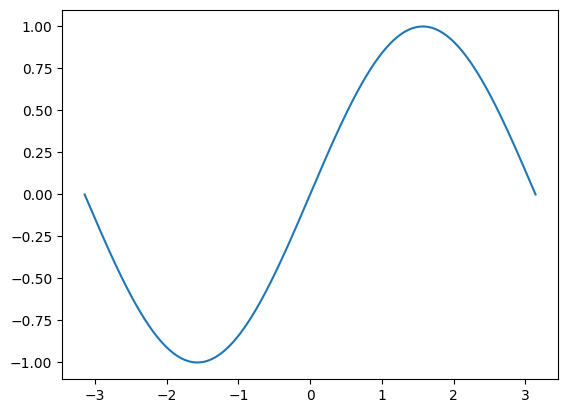

In [11]:
# Ejemplo, crea datos para y = sin(x)

import math
import numpy as np

x = np.linspace(-math.pi, math.pi, 2000, dtype=np.float32)
y = np.sin(x, dtype=np.float32)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x,y)

In [12]:
# convertir tensores numpy a pytorch: torch.from_numpy()
# convertir datos torch a numpy: X.cpu().numpy()
# enviar datos a la GPU: X.to(device)

import torch
device = set_device()

X = torch.from_numpy(x) # convierte a torch
Y = torch.from_numpy(y)

print(Y)
print(Y.device)

Y = Y.to(device) # envía a GPU
print(Y.device)

Using mps device
tensor([ 8.7423e-08, -3.1432e-03, -6.2863e-03,  ...,  6.2863e-03,
         3.1432e-03, -8.7423e-08])
cpu
mps:0


In [13]:
def train (X, Y, model, loss_fn, optimizer, epochs=1000, device='cpu', trace=100): # train sin batches
    size = len(X)
    model = model.to(device)
    model.train() # indica que vamos a entrenar
    Xg, Yg = X.to(device), Y.to(device)
    for e in range(epochs): # bucle de entrenamiento
        optimizer.zero_grad() # reset gradients

        pred = model(Xg) # propagate
        loss = loss_fn(pred, Yg) # prediction error

        loss.backward() # back propagation
        optimizer.step() # update parameters

        if (e+1) % trace == 0: # traces
            loss, current = loss.item(), e+1
            print(f"loss: {loss:>7f}  [{current:>5d} /{epochs:>5d}]")

In [ ]:
# modelo para aprender la función seno

model = basic_MLP(1, 500, 1)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train(X, Y, model, loss_fn, optimizer, 1000, device=device, trace=100)